In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import ipywidgets as widgets
import scipy.integrate as integrate

from ipywidgets import interact, fixed
from scipy.interpolate import interp1d
from textwrap import dedent
from matplotlib import animation
from bokeh.io import push_notebook, show, output_notebook, output_file, curdoc
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.themes import built_in_themes
from bokeh.models import Range1d, BasicTickFormatter, Label

# plot bokeh in notebook format
output_notebook()
curdoc().theme = 'dark_minimal'

Loading BokehJS ...

# Inhomogeneous Semiconductors (Chapter 7)

The notebook at hand will lead you through some important concepts about an inhomogeneous semiconductor. The model look at take here is simply the conjunction of two homogeneous semiconductors with a variable doping concentration.


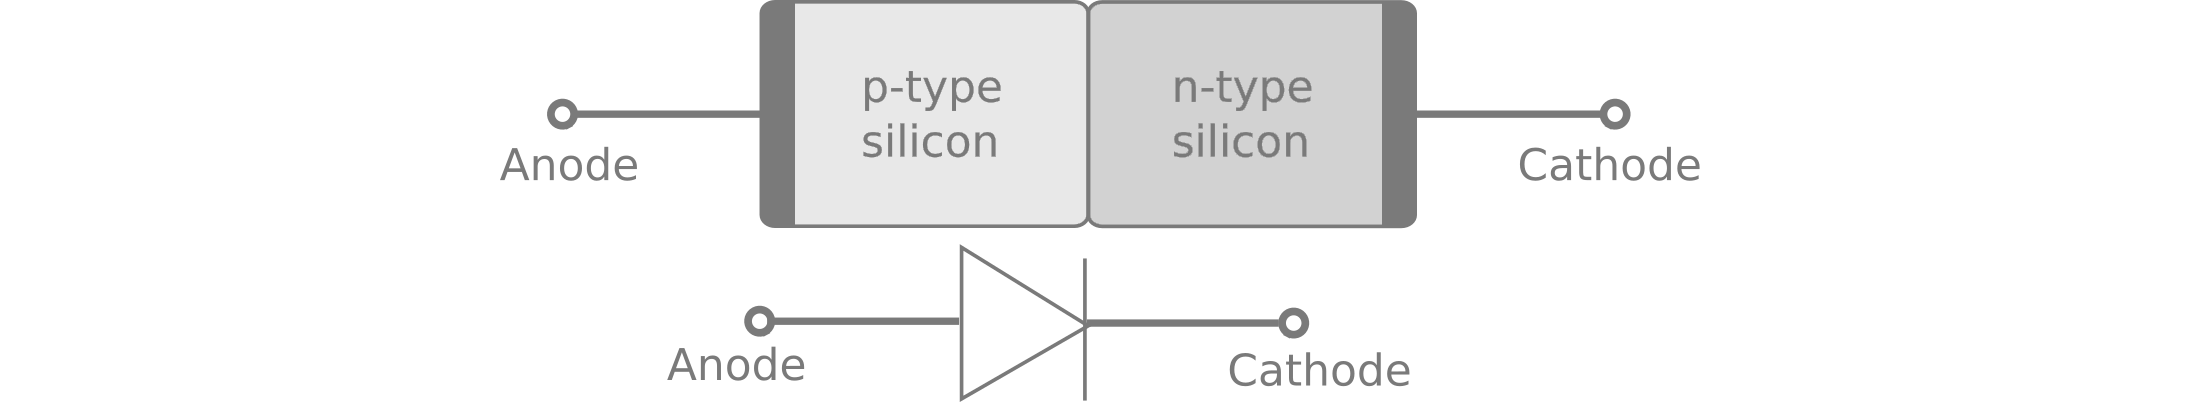

In [2]:
# define constants
kB = 1.380649e-23 # J/K
hbar = 6.626e-34 / (2*np.pi) # J*s
e = 1.60217733e-19 # C
m0 = 9.109383e-31 # kg
T = 300 # K
epsilon0 = 8.854187e-12 # F/m
kBeV = kB/e
Nmin = 1e16; Nmax = 1e18 # cm^-3

# define semiconductor properties
semiconductorList = ['Si', 'Ge','GaAs']
Eg_ = np.array([1.11, 0.66, 1.43]) # Bandgap / eV
me_ = np.array([1.09, 0.55, 0.067]) # average effective electron mass
mh_ = np.array([1.15, 0.37, 0.45]) # average effective hole mass
epsilonR_ = np.array([11.9, 16.2, 13.1]) # relative permittivity

Since there are several parameters associated to a pn junction let us define a *pn* to pass around all of them in a comprehensible fashion.

In [14]:
class pn(object):
    # The class "constructor" - It's actually an initializer 
    def __init__(self, semiconductor = 'Si'):
        self.semiconductor = semiconductor
        self.nd = 4e17
        self.na = 5e17
    
    # change pn junction type and get associated parameters
    def set_semiconductor(self, semiconductor):
        i = semiconductorList.index(semiconductor)
        self.eg, self.me, self.mh, self.epsilon = Eg_[i], me_[i]*m0, mh_[i]*m0, epsilonR_[i]*epsilon0
        return "Bandgap: {} eV".format(self.eg)
    
    # set p & n doping   
    def set_doping(self, Nd, Na):
        self.nd = Nd
        self.na = Na
        
    # calculate pn-junction properties depending on bandgap and doping
    def get_properties(self):
        self.nc = 1/4* ( 2*self.me*kB*T / (np.pi*hbar**2) )**(3/2) *1e-6 # cm^-3
        self.nv = 1/4* ( 2*self.mh*kB*T / (np.pi*hbar**2) )**(3/2) *1e-6 # cm^-3

        self.ni = (self.nc*self.nv)**(1/2) * np.exp(-self.eg / (2*kBeV*T))

        self.e_Delta_phi = ( self.eg + kBeV*T*np.log(self.nd*self.na / (self.nc*self.nv)) )
        
        # equation for dn, dn length
        def dnp(doping = 'n'):
            if doping == 'n': exponent = 1;
            elif doping == 'p': exponent = -1;
             # factor 1e6 for cm^-3, 1e10 for Angstrom
            return ( (self.na/self.nd)**exponent / ((self.na+self.nd) *1e6) * 2 
                   * self.epsilon * self.e_Delta_phi / e )**(1/2) * 1e10

        self.dn = dnp(doping = 'n')
        self.dp = dnp(doping = 'p')
        return (self.dp, self.dn, self.na, self.nd)

    # print calculated pn-junction properties
    def print_properties(self):
        str ='''
        Intrinsic carrier density: \t {:.1e} cm^-3
        Potential difference: \t\t {:.2f} eV
        Space charge in p, n: \t\t {:.0f} Å, {:.0f} Å
        '''.format(self.ni, self.e_Delta_phi, self.dp, self.dn)
        return print(dedent(str))
    
    # calculate carrier density
    def carrier_density(self, x):
        return np.piecewise(x, [x < -self.dp, ((-self.dp <= x) & (x < 0)), ((0 <= x) & (x <= self.dn)), self.dn < x],
                            [self.na, 0, 0, self.nd])

    # calculate charge density
    def charge_density(self, x):
        return np.piecewise(x, [x < -self.dp, ((-self.dp <= x) & (x < 0)), ((0 <= x) & (x <= self.dn)), self.dn < x],
                            [0, -self.na, self.nd, 0])

    # calculate potential / Ascroft & Mermin p596-597
    def phi1(self, x):
        return (2*np.pi*e * self.na*1e6 / self.epsilon) * (((x + self.dp)/1e10)**2 - (self.dp/1e10)**2)
    def phi2(self, x):
        return (2*np.pi*e * self.nd*1e6 / self.epsilon) * ((self.dn/1e10)**2 - ((x - self.dn)/1e10)**2)
    def potential(self, x):
        return np.piecewise(x, [x < -self.dp, ((-self.dp <= x) & (x < 0)), ((0 <= x) & (x <= self.dn)), self.dn < x],
                            [self.phi1(x = -self.dp), self.phi1, self.phi2, self.phi2(x = self.dn)]) / self.epsilon*epsilon0 # <- why?

# create pn-junction object
pn1 = pn()
pn1.set_semiconductor(pn1.semiconductor);

Here you can chose which semiconductor you would like to work with and therefore the associated parameters.

In [15]:
# get parameters for selected semiconductor
def f(pnx, semiconductor, Nd, Na):
    a = pnx.set_semiconductor(semiconductor)
    pnx.set_doping(Nd,Na)
    
    str ='''
    Bandgap:\t\t\t\t{} eV
    Density of donor impurities: \t\t{:1.1e} cm^-3
    Density of acceptor impurities: \t{:1.1e} cm^-3\
    '''.format(pnx.eg, pnx.nd, pnx.na)
    print(dedent(str))
    return pnx

# create widget object for user interaction
w1 = widgets.Dropdown(description = "Select semiconductor:",
                     options = semiconductorList,
                     style = {'description_width': 'initial'})
kwargs = {'min': np.log10(Nmin), 'max': np.log10(Nmax), 'continuous_update': False,
        'step': .02, 'readout': False, 'style': {'description_width': 'initial'}}
w2 = widgets.FloatLogSlider(description = "$N_d$", value=pn1.nd , **kwargs)
w3 = widgets.FloatLogSlider(description = "$N_a$", value=pn1.na , **kwargs)
ui = widgets.VBox([w1,w2,w3])
out = widgets.interactive_output(f, {'pnx': fixed(pn1), 'semiconductor': w1, 'Nd': w2, 'Na': w3})
# show widget
display(ui, out)

Output()

### Intrinsic carrier density

Recall that the effective density of states is given by the following equation (7.17)

$$
N_{c}(T)=\frac{1}{4}\left(\frac{2 m_{c} k_{B} T}{\pi \hbar^{2}}\right)^{3 / 2} \qquad 
P_{v}(T)=\frac{1}{4}\left(\frac{2 m_{v} k_{B} T}{\pi \hbar^{2}}\right)^{3 / 2}
$$

and we can then deduce the intrinsic carrier density from the _law of mass action_ as (7.19)

$$
n_{i}(T)=[N(T) P(T)]^{1 / 2} \exp \left(-\frac{E_{g}}{2 k_{B} T}\right)
$$

Within our approximation of the charge density being non-zero only inside the depletion region delimited by $d_n$, $d_p$, we found that those widths can be calculated by

$$
d_{n, p}=\left\{\frac{\left(N_{a} / N_{d}\right)^{\pm 1}}{\left(N_{d}+N_{a}\right)} \frac{\epsilon \Delta \phi}{2 \pi e}\right\}^{1 / 2}
$$

In [16]:
# print the calculated properties
pn1.get_properties()
pn1.print_properties()


Intrinsic carrier density: 	 1.4e+10 cm^-3
Potential difference: 		 0.89 eV
Space charge in p, n: 		 323 Å, 404 Å



In [43]:
# define 1D axis along pn-junction
a = 1.5
N = 2**9+ 1
dp, dn, na, nd = pn1.get_properties()
xMax = np.maximum(dn, dp)*a
x = np.linspace(-xMax,xMax, N)

# plot carrier & charge densities, potential
def plot_analytic_bokeh(pnx, x):
    # create the plots
    kwars = {'plot_width':800, 'plot_height': 200}
    s1 = figure(title = 'Carrier density',y_range=(0, Nmax), **kwars)
    s1.yaxis.axis_label = 'cm^-3'
    s1.yaxis.formatter = BasicTickFormatter(precision = 0)
    s1.add_layout(Label(text = "p-type", x = -300, y = 6e17, text_align = 'center', text_color = '#4f86f7'))
    s1.add_layout(Label(text = "n-type", x = 300, y = 6e17, text_align = 'center', text_color = '#4f86f7'))
    r1 = s1.line(x, pn1.carrier_density(x),line_width = 3)
    
    s2 = figure(title = 'Charge density',y_range=(-Nmax, Nmax), **kwars)
    s2.yaxis.formatter = BasicTickFormatter(precision = 0)
    r2 = s2.line(x, pn1.charge_density(x),line_width = 3)
    s2.yaxis.axis_label = 'cm^-3'
    
    s3 = figure(title = 'Potential',y_range=(-1.1, 1.1), **kwars)
    r3 = s3.line(x, pn1.potential(x),line_width = 3)
    s3.xaxis.axis_label = 'x [Å]'
    s3.yaxis.axis_label = 'V'
    
    s = [s1,s2,s3]; r = [r1,r2,r3]
    
    for sx in s:
        sx.x_range = Range1d(-xMax, xMax)
    return s, r
    
def plot_update_bokeh(pnx, r, x):
    r[0].data_source.data['y'] = pn1.carrier_density(x)
    r[1].data_source.data['y'] = pn1.charge_density(x)
    r[2].data_source.data['y'] = pn1.potential(x)
    push_notebook()
    return

# show plots
s, r = plot_analytic_bokeh(pn1, x)
show(column(s), notebook_handle=True);
plot_update_bokeh(pn1, r,x)

In [44]:
# show plots
s, r= plot_analytic_bokeh(pn1, x)
show(column(s), notebook_handle=True)
plot_update_bokeh(pn1, r, x)

# now let us change this diagramm interactively
def f2(semiconductor, Nd, Na, pnx = pn1, x = x, r = r):
    f(pnx, semiconductor, Nd, Na)
    pnx.get_properties()
    plot_update_bokeh(pn1, r, x)

out = widgets.interactive_output(f2,  {'semiconductor': w1, 'Nd': w2, 'Na': w3})
display(ui, out)

Output()

In [63]:
def plot_grid(axes):
    for axis in axes:
        axis.axhline(0, c = 'silver', linewidth = .5)
        axis.axvline(0, c = 'silver', linewidth = .5)

# nobody reads this
def plot_analytic():
    # define 1D axis along pn-junction
    a = 1.5
    N = 2**10+ 1
    dp, dn, na, nd = pn1.get_properties()
    xMax = np.maximum(dn, dp)*a
    x = np.linspace(-xMax,xMax, N)
    
    fig, ax = plt.subplots(3, 1, sharex=True,figsize=(10,6),dpi=100)
    
    # plot things
    ax[0].title.set_text('Carrier density')
    plt.xlabel('x [$\AA$]')
    plt.xlim(-xMax,xMax)
    ax[0].set_ylabel('$cm^{-3}$')
    ax[0].plot(x,pn1.carrier_density(x))
    ax[0].text(-dp/2, na/2,'p-type',horizontalalignment='center')
    ax[0].text(dn/2, na/2,'n-type',horizontalalignment='center')

    ax[1].title.set_text('Charge density')
    ax[1].set_ylabel('$cm^{-3}$')
    ax[1].plot(x,pn1.charge_density(x))

    ax[2].title.set_text('Potential')
    ax[2].set_ylabel('V')
    ax[2].plot(x,pn1.potential(x))
    plot_grid([ax[0],ax[1],ax[2]]);
    return fig, ax, x
    
def plot_update(fig, ax, x):
    plt.figure(fig.number)
    ax[0].plot(x,pn1.carrier_density(x))
    ax[1].plot(x,pn1.charge_density(x))
    ax[2].plot(x,pn1.potential(x))
    
    fig.canvas.draw()
    fig.canvas.flush_events()
    return

def plot_analytic_bokeh():
    # define 1D axis along pn-junction
    a = 1.5
    N = 2**9+ 1
    dp, dn, na, nd = pn1.get_properties()
    xMax = np.maximum(dn, dp)*a
    x = np.linspace(-xMax,xMax, N)
    
    # create the plots
    kwars = {'plot_width':800, 'plot_height': 200}
    s1 = figure(title = 'Carrier density',y_range=(Nmin, Nmax), **kwars)
    s1.yaxis.axis_label = 'cm^-3'
    s1.yaxis.formatter = BasicTickFormatter(precision = 0)
    r1 = s1.line(x, pn1.carrier_density(x),line_width = 3)
    
    
    s2 = figure(title = 'Charge density',y_range=(-Nmax, Nmax), **kwars)
    s2.yaxis.formatter = BasicTickFormatter(precision = 0)
    r2 = s2.line(x, pn1.charge_density(x),line_width = 3)
    s2.yaxis.axis_label = 'cm^-3'
    
    s3 = figure(title = 'Potential',y_range=(-1, 1), **kwars)
    r3 = s3.line(x, pn1.potential(x),line_width = 3)
    s3.xaxis.axis_label = 'x [Å]'
    s3.yaxis.axis_label = 'V'
    
    s = [s1,s2,s3]; r = [r1,r2,r3]
    
    for sx in s:
        sx.x_range = Range1d(-xMax, xMax)
    return s, r, x
    
def plot_update_bokeh(r, x, handle):
    r[0].data_source.data['y'] = pn1.carrier_density(x)
    r[1].data_source.data['y'] = pn1.charge_density(x)
    r[2].data_source.data['y'] = pn1.potential(x)
    push_notebook(handle=handle)
    return
    
s, r, x = plot_analytic_bokeh()

# show plots
handle = show(column(s), notebook_handle=True);
plot_update_bokeh(r,x, handle)

#plot_analytic();

In [64]:
s, r, x = plot_analytic_bokeh()

# now let us change this diagramm interactively
def f2(semiconductor, Nd, Na, x = x, r = r, handle = handle):
    f(semiconductor, Nd, Na)
    plot_update_bokeh(r, x, handle = handle)

# show plots
handle = show(column(s), notebook_handle=True)
plot_update_bokeh(r,x, handle)

out = widgets.interactive_output(f2,  {'semiconductor': w1, 'Nd': w2, 'Na': w3})
display(ui, out)
r

Output()

[GlyphRenderer(id='33175', ...),
 GlyphRenderer(id='33216', ...),
 GlyphRenderer(id='33255', ...)]

In [48]:
x = np.array([-146.  , -136.  , -126.  , -116.  , -106.  ,  -96.  ,  -86.  ,
         -76.  ,  -66.  ,  -58.  ,  -53.  ,  -48.  ,  -43.  ,  -38.  ,
         -33.  ,  -28.  ,  -23.  ,  -19.  ,  -16.5 ,  -14.  ,  -11.5 ,
          -9.  ,   -6.5 ,   -4.  ,   -1.5 ,    0.75,    3.25,    5.75,
           8.25,   10.75,   13.25,   15.75,   18.25,   21.5 ,   26.5 ,
          31.5 ,   36.5 ,   41.5 ,   46.5 ,   51.5 ,   56.5 ,   63.  ,
          73.  ,   83.  ,   93.  ,  103.  ,  113.  ,  123.  ,  133.  ,
         143.  ])
spaceCharge=np.array([-1.04647e-04, -2.16539e-04, -5.81861e-04, -1.62462e-03,
        -4.53152e-03, -1.24302e-02, -3.25418e-02, -7.58595e-02,
        -1.39543e-01, -1.79867e-01, -1.92558e-01, -1.97879e-01,
        -1.99537e-01, -1.99923e-01, -1.99990e-01, -1.99999e-01,
        -2.00000e-01, -2.00000e-01, -2.00000e-01, -2.00000e-01,
        -2.00000e-01, -2.00000e-01, -2.00000e-01, -2.00000e-01,
        -2.00000e-01,  3.00000e-01,  3.00000e-01,  3.00000e-01,
         3.00000e-01,  2.99999e-01,  2.99996e-01,  2.99985e-01,
         2.99944e-01,  2.99741e-01,  2.98016e-01,  2.89897e-01,
         2.65645e-01,  2.19665e-01,  1.61602e-01,  1.07818e-01,
         6.72400e-02,  3.42751e-02,  1.14088e-02,  3.68516e-03,
         1.17887e-03,  3.75955e-04,  1.19799e-04,  3.82260e-05,
         1.23965e-05,  4.64809e-06])
potential=np.array([-0.78429, -0.78428, -0.78423, -0.7841 , -0.78371, -0.78264,
        -0.77969, -0.77191, -0.75325, -0.72478, -0.69904, -0.66659,
        -0.62722, -0.58087, -0.52753, -0.46719, -0.39986, -0.34095,
        -0.30186, -0.26102, -0.21844, -0.1741 , -0.12801, -0.08017,
        -0.03059,  0.01534,  0.06475,  0.11154,  0.1557 ,  0.19724,
         0.23616,  0.27245,  0.30611,  0.34596,  0.39861,  0.44086,
         0.47301,  0.49593,  0.5112 ,  0.52081,  0.5266 ,  0.5307 ,
         0.53331,  0.53415,  0.53442,  0.53451,  0.53453,  0.53454,
         0.53455,  0.53455])

# data from pn-junction simulation nextnano
# https://www.nextnano.com/nextnano3/tutorial/1Dtutorial_pn_junction.htm

# convert units from numerical simulation
x_num = x*10 # Angstrom
spaceCharge = spaceCharge*1e18 # cm^-3
potential = potential # V

# smooth out sampled data
def spaceCharge_interpolated(x, x_num = x_num, spaceCharge = spaceCharge):
    return np.piecewise(x, [x < 0, x >= 0], [interp1d(x_num[x_num<0],spaceCharge[x_num<0],kind='cubic',fill_value="extrapolate"),
                interp1d(x_num[x_num>=0],spaceCharge[x_num>=0],kind='cubic',fill_value="extrapolate")])

potential_interpolated = interp1d(x_num,potential,kind='cubic',fill_value="extrapolate")

x = np.linspace(x_num[0],x_num[-1],300)

# define semiconductor for comparison
pn2 = pn()
pn2.set_semiconductor('GaAs')
pn2.set_doping(Na = 0.2e18, Nd = 0.3e18)
dp, dn, na, nd = pn2.get_properties()

# plot figures
kwars = {'plot_width':800, 'plot_height': 300}
s1 = figure(title = 'Carrier density', **kwars)
s1.yaxis.axis_label = 'cm^-3'
s1.yaxis.formatter = BasicTickFormatter(precision = 0)
s1.add_layout(Label(text = "p-type", x=-dp/2, text_align = 'center', text_color = '#4f86f7'))
s1.add_layout(Label(text = "n-type", x=dn/2, text_align = 'center', text_color = '#4f86f7'))
r1 = s1.line(x,spaceCharge_interpolated(x), legend_label='numerical solution', line_width = 3, line_color="orange")
r12 = s1.line(x, pn2.charge_density(x), legend_label='analytical approximation', line_width = 3)

s2 = figure(title = 'Potential', **kwars)
s2.yaxis.formatter = BasicTickFormatter(precision = 0)
s2.yaxis.axis_label = 'V'
r2 = s2.line(x, potential_interpolated(x), legend_label='numerical solution', line_width = 3, line_color="orange")
r22 = s2.line(x, pn2.potential(x), legend_label='analytical approximation', line_width = 3)
s2.xaxis.axis_label = 'x [Å]'

show(column([s1,s2]));